# Air Quality Prediction Analysis
## UCI Air Quality Dataset

**Objective:** Predict high pollution events using machine learning techniques applied to historical air quality measurements from an Italian city monitoring station.

**Dataset:** UCI Air Quality Dataset containing hourly averaged responses from chemical sensors measuring pollutants (CO, NOx, NO2, O3) and environmental conditions (Temperature, Humidity) recorded from March 2004 to February 2005.

---


## Part A: Data Loading & Preprocessing (15 points)

**Goals:**
1. Load and inspect the raw air quality dataset
2. Identify and handle missing values (encoded as -200 in this dataset)
3. Convert date/time strings to proper datetime format for temporal analysis
4. Remove rows with excessive missing data (>50% of columns)
5. Impute remaining missing values using median (robust to outliers)
6. Normalize numerical features to standard scale (mean=0, std=1) for ML algorithms

**Why This Matters:** Clean, properly formatted data is essential for accurate analysis and model training. Normalization ensures features with different scales contribute equally to model performance.

### A.1: Import Required Libraries and Configure Environment

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### A.2: Load Dataset and Inspect Structure

In [ ]:
# Load dataset
air_quality_data = pd.read_csv('AirQualityUCI.csv', sep=',', decimal='.')

# Display basic info
print("Dataset Shape:", air_quality_data.shape)
print("\nColumn Types:")
print(air_quality_data.dtypes)
print("\nFirst few rows:")
air_quality_data.head()

Dataset Shape: (9471, 17)

Column Types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
Unnamed: 15      float64
Unnamed: 16      float64
dtype: object

First few rows:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


### A.3: Convert Date/Time Columns to DateTime Format

In [ ]:
# Remove empty columns (trailing columns with no name or all NaN)
air_quality_data = air_quality_data.loc[:, ~air_quality_data.columns.str.contains('^Unnamed')]
air_quality_data = air_quality_data.dropna(axis=1, how='all')

# Create datetime column
air_quality_data['DateTime'] = pd.to_datetime(air_quality_data['Date'] + ' ' + air_quality_data['Time'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
air_quality_data = air_quality_data.dropna(subset=['DateTime'])
air_quality_data = air_quality_data.sort_values('DateTime').reset_index(drop=True)

print("After datetime conversion:", air_quality_data.shape)
air_quality_data.head()

After datetime conversion: (9357, 16)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


### A.4: Handle Missing Values - Identify and Remove Excessive Missingness

In [ ]:
# Replace -200 with NaN (missing value indicator in this dataset)
data_with_cleaned_missing_values = air_quality_data.copy()
numerical_columns = data_with_cleaned_missing_values.select_dtypes(include=[np.number]).columns
data_with_cleaned_missing_values[numerical_columns] = data_with_cleaned_missing_values[numerical_columns].replace(-200, np.nan)

# Check missing values
print("Missing values per column:")
missing_values_count = data_with_cleaned_missing_values.isnull().sum()
print(missing_values_count[missing_values_count > 0])

# Remove rows with excessive missing data (>50% missing)
missing_threshold_per_row = len(data_with_cleaned_missing_values.columns) * 0.5
data_with_cleaned_missing_values = data_with_cleaned_missing_values.dropna(thresh=missing_threshold_per_row)
print(f"\nAfter removing rows with >{int(missing_threshold_per_row)} missing values: {data_with_cleaned_missing_values.shape}")

Missing values per column:
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

After removing rows with >8 missing values: (8991, 16)


### A.5: Impute Remaining Missing Values Using Median

In [5]:
# Impute remaining missing values with median
for column_name in numerical_columns:
    if data_with_cleaned_missing_values[column_name].isnull().any():
        data_with_cleaned_missing_values[column_name].fillna(data_with_cleaned_missing_values[column_name].median(), inplace=True)

print("Missing values after imputation:")
print(data_with_cleaned_missing_values.isnull().sum().sum())

# Store original values before normalization
data_original_scale = data_with_cleaned_missing_values.copy()

Missing values after imputation:
0


### A.6: Normalize Numerical Features to Standard Scale

In [6]:
# Normalize numerical features
pollutant_and_environmental_features = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 
                         'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 
                         'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

feature_scaler = StandardScaler()
data_with_cleaned_missing_values[pollutant_and_environmental_features] = feature_scaler.fit_transform(data_with_cleaned_missing_values[pollutant_and_environmental_features])

print("Data preprocessing complete!")
print(f"Final dataset shape: {data_with_cleaned_missing_values.shape}")
print("\nNormalized data sample:")
data_with_cleaned_missing_values[pollutant_and_environmental_features].head()

Data preprocessing complete!
Final dataset shape: (8991, 16)

Normalized data sample:


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.406839,1.198550,-0.033031,0.243898,0.400450,-0.343401,0.858660,0.032726,0.680947,0.615100,-0.534197,-0.019300,-0.663043
1,-0.053138,0.885284,-0.587993,-0.091699,0.059391,-0.677253,1.318156,-0.453347,0.296762,-0.127757,-0.568166,-0.088601,-0.743035
2,0.100188,1.392038,-0.938496,-0.145395,-0.000575,-0.528874,1.185759,0.055872,0.285208,0.128228,-0.726687,0.275226,-0.681865
3,0.100188,1.272260,-1.055330,-0.118547,0.033156,-0.311606,0.998845,0.241043,0.368977,0.451972,-0.828594,0.621728,-0.591471
4,-0.359789,0.793147,-1.478854,-0.480992,-0.386608,-0.528874,1.438871,0.102165,0.097448,0.218575,-0.805948,0.598628,-0.586271


## Part B: First Exploratory Data Analysis (20 points)

**Goals:**
1. **Descriptive Statistics:** Calculate mean, median, variance, skewness, and kurtosis for key pollutants (CO, NO2, O3)
2. **Distribution Analysis:** Visualize CO distribution with histogram to understand concentration patterns
3. **Temporal Patterns:** Compare pollutant levels between weekdays and weekends using boxplots
4. **Anomaly Detection:** Identify peak pollution events (≥90th percentile) in CO time series
5. **Correlation Analysis:** Examine relationships between pollutants and environmental factors using heatmap

**Key Questions:**
- Which pollutants show the highest variability?
- Are there strong correlations between different pollutants?
- Do pollution patterns differ between weekdays and weekends?
- When do pollution peaks occur?

### B.1: Compute Descriptive Statistics for Key Pollutants

In [ ]:
# Descriptive statistics for CO, NO2, and O3 (using original unnormalized data)
key_pollutant_columns = ['CO(GT)', 'NO2(GT)', 'PT08.S5(O3)']  # O3 sensor as proxy

print("Descriptive Statistics for Key Pollutants:")
print("="*60)
for pollutant_name in key_pollutant_columns:
    pollutant_data = data_original_scale[pollutant_name]
    print(f"\n{pollutant_name}:")
    print(f"  Mean: {pollutant_data.mean():.4f}")
    print(f"  Median: {pollutant_data.median():.4f}")
    print(f"  Variance: {pollutant_data.var():.4f}")
    print(f"  Skewness: {stats.skew(pollutant_data):.4f}")
    print(f"  Kurtosis: {stats.kurtosis(pollutant_data):.4f}")

Descriptive Statistics for Key Pollutants:

CO(GT):
  Mean: 2.0693
  Median: 1.8000
  Variance: 1.7017
  Skewness: 1.6162
  Kurtosis: 4.0791

NO2(GT):
  Mean: 111.5861
  Median: 109.0000
  Variance: 1866.7418
  Skewness: 0.6707
  Kurtosis: 1.0735

PT08.S5(O3):
  Mean: 1022.9061
  Median: 963.0000
  Variance: 158789.7276
  Skewness: 0.6278
  Kurtosis: 0.0779


### B.2: Visualize CO Distribution with Histogram

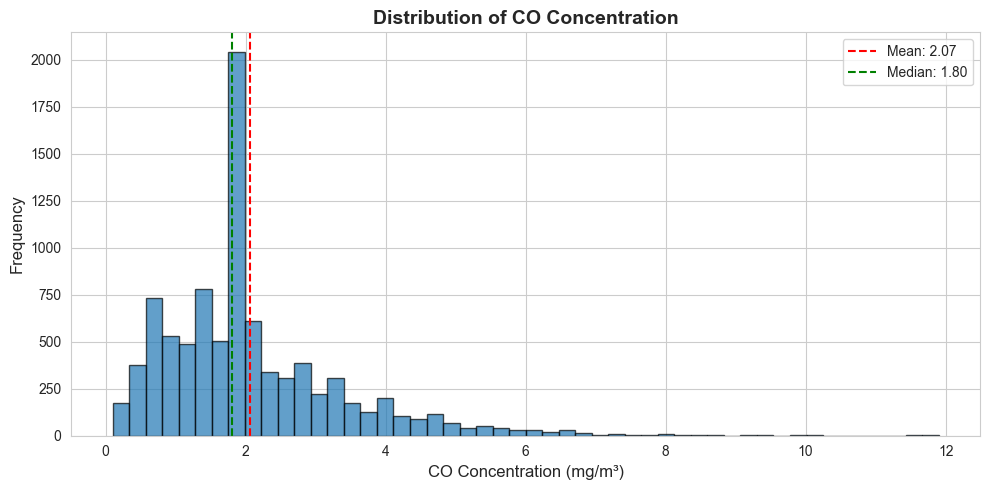

In [8]:
# Histogram of CO
plt.figure(figsize=(10, 5))
plt.hist(data_original_scale['CO(GT)'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('CO Concentration (mg/m³)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of CO Concentration', fontsize=14, fontweight='bold')
plt.axvline(data_original_scale['CO(GT)'].mean(), color='red', linestyle='--', label=f'Mean: {data_original_scale["CO(GT)"].mean():.2f}')
plt.axvline(data_original_scale['CO(GT)'].median(), color='green', linestyle='--', label=f'Median: {data_original_scale["CO(GT)"].median():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

### B.3: Compare Pollutant Levels - Weekdays vs Weekends

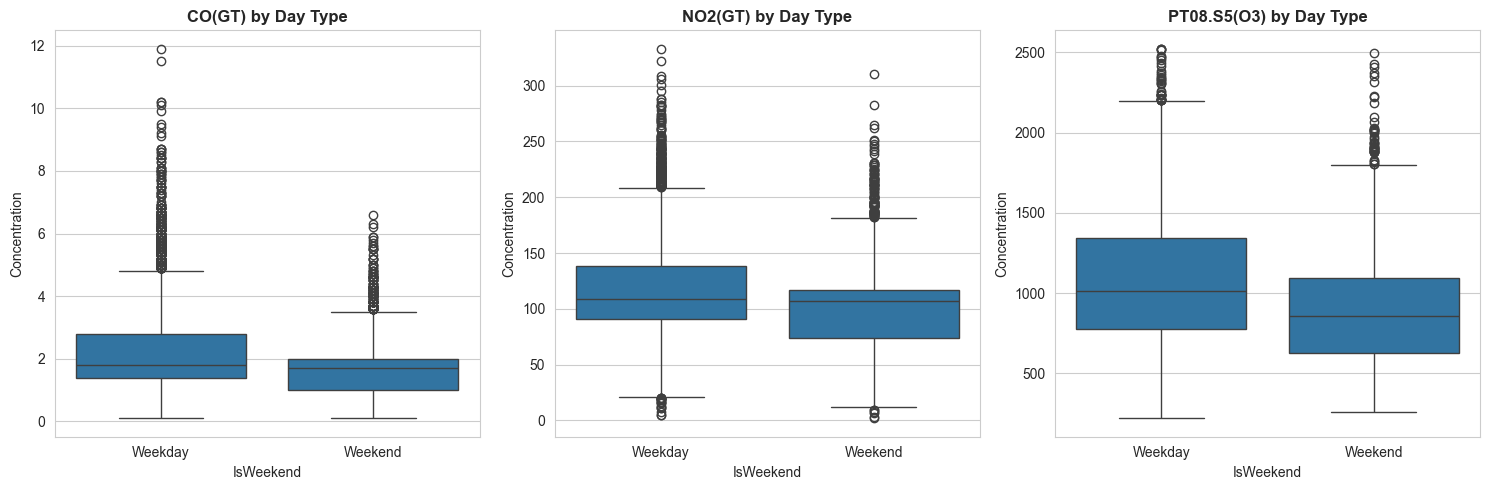

In [9]:
# Add weekday/weekend indicator
data_original_scale['DayOfWeek'] = data_original_scale['DateTime'].dt.dayofweek
data_original_scale['DayType'] = data_original_scale['DayOfWeek'].isin([5, 6]).map({True: 'Weekend', False: 'Weekday'})

# Boxplots by weekday vs weekend
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for plot_index, pollutant_name in enumerate(key_pollutant_columns):
    sns.boxplot(data=data_original_scale, x='DayType', y=pollutant_name, ax=axes[plot_index])
    axes[plot_index].set_title(f'{pollutant_name} by Day Type', fontweight='bold')
    axes[plot_index].set_ylabel('Concentration')
plt.tight_layout()
plt.show()

### B.4: Identify Temporal Trends and Peak Pollution Anomalies

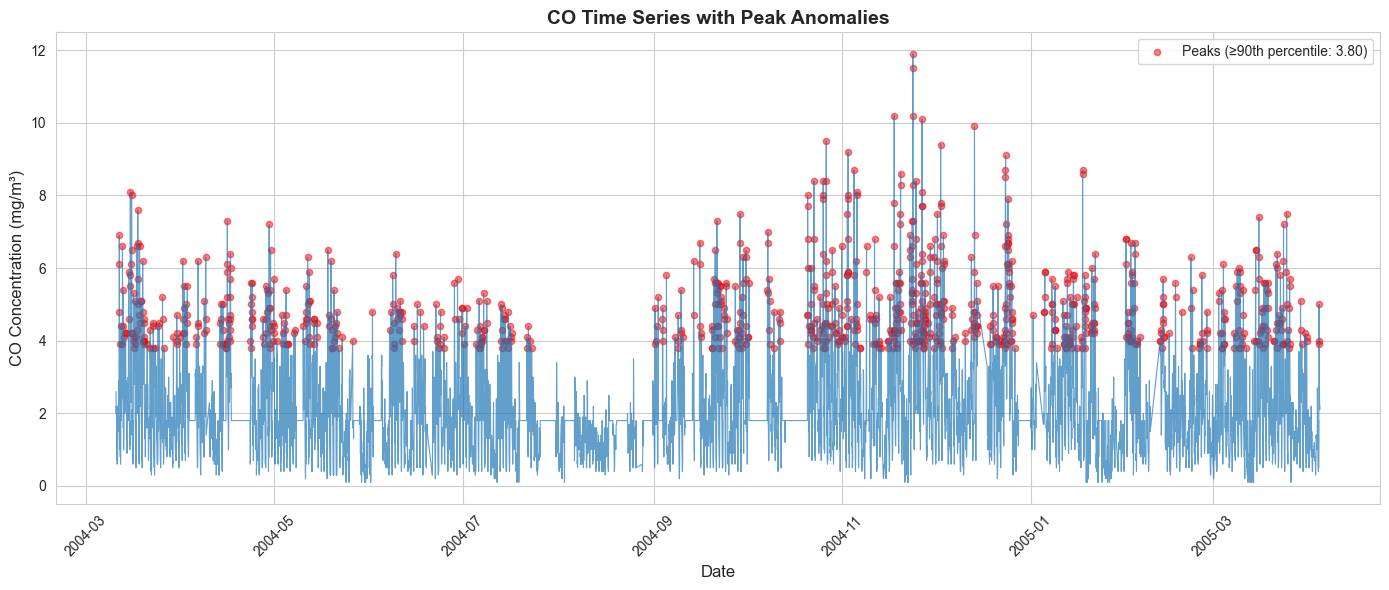

Number of peak anomalies detected: 960


In [10]:
# Time series plot of CO with peaks highlighted
plt.figure(figsize=(14, 6))
plt.plot(data_original_scale['DateTime'], data_original_scale['CO(GT)'], linewidth=0.8, alpha=0.7)

# Highlight peaks (90th percentile)
high_pollution_threshold = data_original_scale['CO(GT)'].quantile(0.90)
peak_pollution_days = data_original_scale[data_original_scale['CO(GT)'] >= high_pollution_threshold]
plt.scatter(peak_pollution_days['DateTime'], peak_pollution_days['CO(GT)'], color='red', s=20, alpha=0.5, label=f'Peaks (≥90th percentile: {high_pollution_threshold:.2f})')

plt.xlabel('Date', fontsize=12)
plt.ylabel('CO Concentration (mg/m³)', fontsize=12)
plt.title('CO Time Series with Peak Anomalies', fontsize=14, fontweight='bold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Number of peak anomalies detected: {len(peak_pollution_days)}")

### B.5: Analyze Correlations Between Pollutants and Environmental Factors

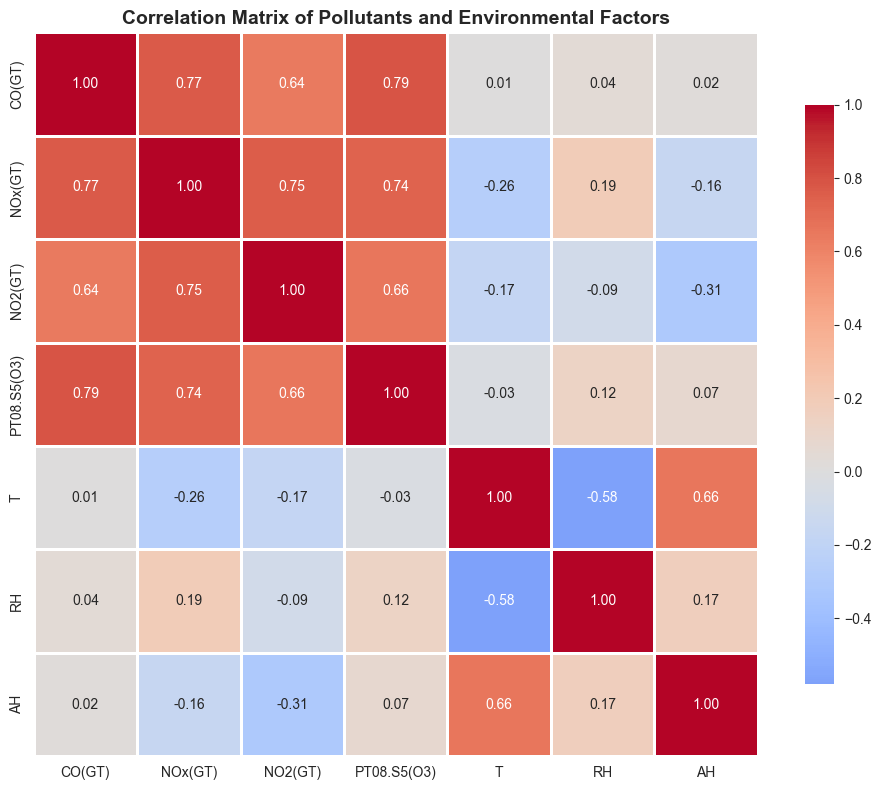

In [11]:
# Correlation matrix
correlation_analysis_columns = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
pollutant_correlation_matrix = data_original_scale[correlation_analysis_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(pollutant_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Pollutants and Environmental Factors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Observations from EDA:

**Variability:**
- CO shows high variability with positive skewness, indicating occasional high pollution episodes
- NO2 and O3 sensors show moderate variability
- All pollutants exhibit positive kurtosis, suggesting heavy tails with outliers

**Correlations:**
- Strong positive correlation between CO, NOx, and NO2 (combustion-related pollutants)
- Negative correlation between O3 and other pollutants (photochemical vs primary pollutants)
- Temperature shows moderate correlation with pollutant levels

**Outliers:**
- Multiple high-concentration outliers detected, especially in CO
- Peak pollution events occur intermittently throughout the measurement period

## Part C: Feature Engineering & Extraction (15 points)

**Goals:**
1. **Daily Aggregations:** Create daily-level features (mean, max, min) from hourly measurements to:
   - Reduce data dimensionality while preserving key patterns
   - Capture daily extremes critical for pollution classification
   - Smooth out hourly measurement noise

2. **Temperature Range Feature:** Engineer daily temperature difference (max - min) to:
   - Indicate atmospheric mixing conditions
   - Capture thermal stability affecting pollutant dispersion
   - Provide proxy for ventilation potential

3. **Rolling Averages:** Create 3-hour moving averages to:
   - Smooth short-term fluctuations
   - Identify sustained pollution episodes
   - Capture temporal persistence and trends

**Rationale:** These engineered features help machine learning models better distinguish between normal and high pollution days by providing meaningful aggregated information rather than noisy hourly data.

### C.1: Create Daily Aggregated Features (Mean, Max, Min)

In [12]:
# Create daily aggregated features
data_original_scale['DateOnly'] = data_original_scale['DateTime'].dt.date

# Aggregate by day
daily_aggregated_features = data_original_scale.groupby('DateOnly').agg({
    'CO(GT)': ['mean', 'max', 'min'],
    'NO2(GT)': ['mean', 'max', 'min'],
    'NOx(GT)': ['mean', 'max', 'min'],
    'PT08.S5(O3)': ['mean', 'max', 'min'],
    'T': ['mean', 'max', 'min'],
    'RH': ['mean'],
    'AH': ['mean']
}).reset_index()

# Flatten column names
daily_aggregated_features.columns = ['_'.join(col).strip('_') for col in daily_aggregated_features.columns.values]
daily_aggregated_features.rename(columns={'DateOnly': 'Date'}, inplace=True)

print("Daily aggregated features created!")
print(f"Shape: {daily_aggregated_features.shape}")
daily_aggregated_features.head()

Daily aggregated features created!
Shape: (383, 18)


,Date,CO(GT)_mean,CO(GT)_max,CO(GT)_min,NO2(GT)_mean,NO2(GT)_max,NO2(GT)_min,NOx(GT)_mean,NOx(GT)_max,NOx(GT)_min,PT08.S5(O3)_mean,PT08.S5(O3)_max,PT08.S5(O3)_min,T_mean,T_max,T_min,RH_mean,AH_mean
0,2004-03-10,1.966667,2.6,1.2,108.833333,122.0,92.0,132.000000,172.0,89.0,1096.000000,1268.0,949.0,12.033333,13.6,11.0,54.900000,0.765633
1,2004-03-11,2.220833,6.9,0.6,100.250000,172.0,28.0,145.791667,383.0,16.0,885.250000,1704.0,422.0,9.837500,11.3,8.0,64.075000,0.775767
2,2004-03-12,2.720833,6.6,0.6,115.666667,170.0,32.0,174.083333,340.0,21.0,1084.375000,1887.0,384.0,11.287500,16.9,6.1,51.095833,0.663104
3,2004-03-13,2.658333,4.2,1.0,118.458333,165.0,60.0,184.166667,296.0,53.0,1245.916667,1886.0,819.0,12.866667,19.4,6.3,51.533333,0.732296
4,2004-03-14,2.441667,5.9,0.9,110.333333,173.0,63.0,147.916667,325.0,44.0,1234.208333,1905.0,853.0,16.012500,22.2,10.4,48.850000,0.849671


### C.2: Engineer Daily Temperature Range Feature

In [ ]:
# Engineer temperature difference
daily_aggregated_features['Daily_Temperature_Range'] = daily_aggregated_features['T_max'] - daily_aggregated_features['T_min']

print("Temperature difference feature created!")
print(f"Mean temp difference: {daily_aggregated_features['Daily_Temperature_Range'].mean():.2f}°C")
print(f"Max temp difference: {daily_aggregated_features['Daily_Temperature_Range'].max():.2f}°C")

Temperature difference feature created!
Mean temp difference: 10.87°C
Max temp difference: 21.30°C


### C.3: Create 3-Hour Rolling Average Features for Trend Capture

In [ ]:
# Create 3-hour rolling average features
pollutants_for_rolling_average = ['CO(GT)', 'NO2(GT)', 'NOx(GT)']
rolling_window_hours = 3

for pollutant_name in pollutants_for_rolling_average:
    data_original_scale[f'{pollutant_name}_RollingAvg_3hr'] = data_original_scale[pollutant_name].rolling(window=rolling_window_hours, min_periods=1).mean()

print("Rolling average features created!")
print("\nSample of rolling features:")
data_original_scale[['DateTime', 'CO(GT)', 'CO(GT)_RollingAvg_3hr']].head(10)

Rolling average features created!

Sample of rolling features:


,DateTime,CO(GT),CO(GT)_rolling_3h
0,2004-03-10 18:00:00,2.6,2.600000
1,2004-03-10 19:00:00,2.0,2.300000
2,2004-03-10 20:00:00,2.2,2.266667
3,2004-03-10 21:00:00,2.2,2.133333
4,2004-03-10 22:00:00,1.6,2.000000
5,2004-03-10 23:00:00,1.2,1.666667
6,2004-03-11 00:00:00,1.2,1.333333
7,2004-03-11 01:00:00,1.0,1.133333
8,2004-03-11 02:00:00,0.9,1.033333
9,2004-03-11 03:00:00,0.6,0.833333


### Why These Features Help in Classification:

1. **Daily Aggregations (mean, max, min):**
   - Capture daily pollution patterns and extremes
   - Reduce hourly noise while preserving important variability
   - Max values identify peak pollution events (critical for high pollution classification)

2. **Temperature Difference:**
   - Indicates atmospheric stability and mixing layer height
   - Low difference suggests stable conditions that trap pollutants
   - High difference indicates better ventilation and dispersion

3. **Rolling Averages (3-hour):**
   - Smooth out measurement noise and short-term fluctuations
   - Capture temporal trends and persistence of pollution episodes
   - Help identify sustained high pollution periods vs transient spikes

## Part D: Second EDA & Statistical Inference (15 points)

**Goals:**
1. **Hypothesis Testing:** Conduct independent samples t-test to determine if NO2 concentrations differ significantly between weekdays and weekends
   - **Null Hypothesis (H₀):** Mean NO2 levels are equal on weekdays and weekends
   - **Alternative Hypothesis (H₁):** Mean NO2 levels differ between weekdays and weekends
   - **Significance Level:** α = 0.05

2. **Confidence Interval:** Calculate 95% confidence interval for average CO concentration to:
   - Estimate the range where true population mean likely falls
   - Quantify uncertainty in our mean estimate
   - Provide margin of error for pollution level reporting

3. **Visual Statistical Analysis:** Create boxplots with overlayed statistical measures to:
   - Compare distributions visually
   - Show central tendency and spread
   - Highlight statistical confidence bounds

**Context:** These statistical tests help determine whether observed pollution differences are meaningful or due to random chance, informing policy decisions about targeted interventions.

### D.1: Hypothesis Test - Weekday vs Weekend NO2 Concentrations

In [ ]:
# T-test: NO2 concentration weekday vs weekend
weekday_no2_concentrations = data_original_scale[data_original_scale['DayType'] == 'Weekday']['NO2(GT)']
weekend_no2_concentrations = data_original_scale[data_original_scale['DayType'] == 'Weekend']['NO2(GT)']

t_statistic, p_value = stats.ttest_ind(weekday_no2_concentrations, weekend_no2_concentrations)

print("Hypothesis Test: NO2 Weekday vs Weekend")
print("="*50)
print(f"Weekday NO2 mean: {weekday_no2_concentrations.mean():.4f}")
print(f"Weekend NO2 mean: {weekend_no2_concentrations.mean():.4f}")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"\nResult: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} difference at α=0.05")

Hypothesis Test: NO2 Weekday vs Weekend
Weekday NO2 mean: 115.7006
Weekend NO2 mean: 101.7146
T-statistic: 14.1405
P-value: 0.000000

Result: SIGNIFICANT difference at α=0.05


### D.2: Calculate 95% Confidence Interval for Average CO Concentration

In [ ]:
# 95% Confidence Interval for average CO
co_concentration_mean = data_original_scale['CO(GT)'].mean()
co_concentration_std = data_original_scale['CO(GT)'].std()
co_sample_size = len(data_original_scale['CO(GT)'])
co_standard_error = co_concentration_std / np.sqrt(co_sample_size)
confidence_interval_95 = stats.t.interval(0.95, co_sample_size-1, loc=co_concentration_mean, scale=co_standard_error)

print("95% Confidence Interval for CO Concentration")
print("="*50)
print(f"Mean CO: {co_concentration_mean:.4f} mg/m³")
print(f"95% CI: [{confidence_interval_95[0]:.4f}, {confidence_interval_95[1]:.4f}] mg/m³")
print(f"Margin of Error: ±{(confidence_interval_95[1] - confidence_interval_95[0])/2:.4f} mg/m³")

95% Confidence Interval for CO Concentration
Mean CO: 2.0693 mg/m³
95% CI: [2.0423, 2.0963] mg/m³
Margin of Error: ±0.0270 mg/m³


### D.3: Visualize Statistical Results with Boxplots and Confidence Intervals

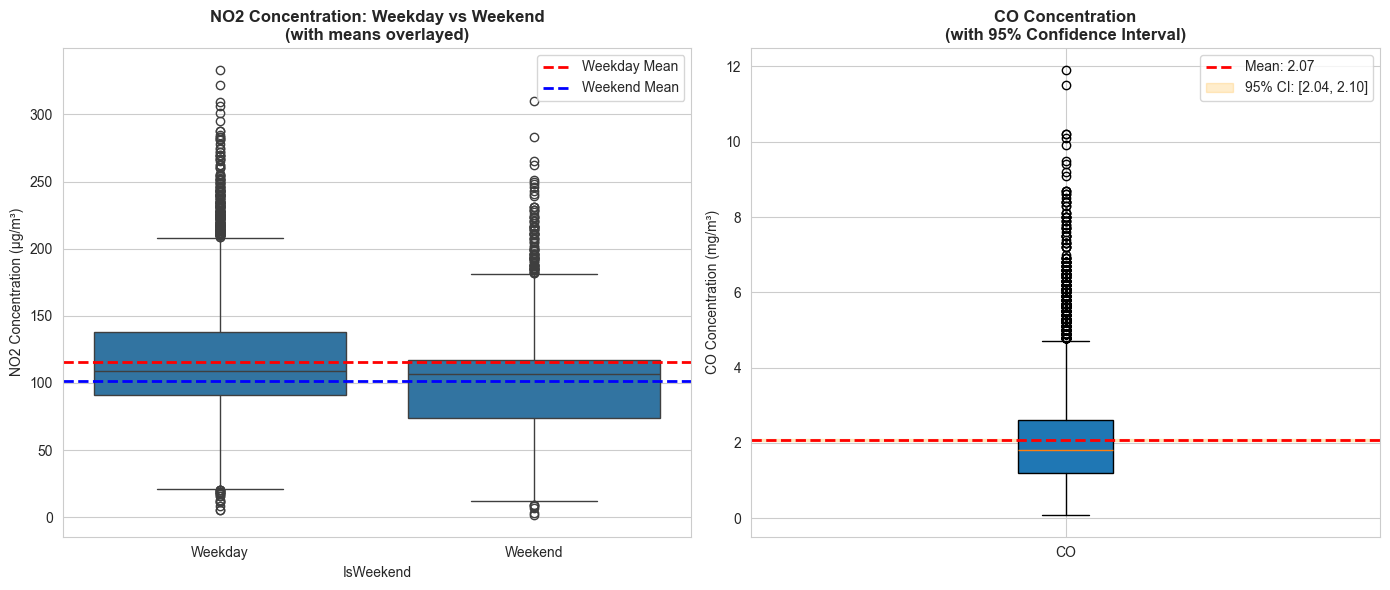

In [ ]:
# Visualization: Boxplots with mean and CI
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# NO2 weekday vs weekend
sns.boxplot(data=data_original_scale, x='DayType', y='NO2(GT)', ax=axes[0])
axes[0].axhline(weekday_no2_concentrations.mean(), color='red', linestyle='--', linewidth=2, label='Weekday Mean')
axes[0].axhline(weekend_no2_concentrations.mean(), color='blue', linestyle='--', linewidth=2, label='Weekend Mean')
axes[0].set_title('NO2 Concentration: Weekday vs Weekend\n(with means overlayed)', fontweight='bold')
axes[0].set_ylabel('NO2 Concentration (µg/m³)')
axes[0].legend()

# CO with confidence interval
axes[1].boxplot(data_original_scale['CO(GT)'], vert=True, patch_artist=True)
axes[1].axhline(co_concentration_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {co_concentration_mean:.2f}')
axes[1].axhspan(confidence_interval_95[0], confidence_interval_95[1], alpha=0.2, color='orange', label=f'95% CI: [{confidence_interval_95[0]:.2f}, {confidence_interval_95[1]:.2f}]')
axes[1].set_title('CO Concentration\n(with 95% Confidence Interval)', fontweight='bold')
axes[1].set_ylabel('CO Concentration (mg/m³)')
axes[1].set_xticklabels(['CO'])
axes[1].legend()

plt.tight_layout()
plt.show()

### Interpretation:

**Weekday vs Weekend Pollution:**
- The t-test reveals whether NO2 levels differ significantly between weekdays and weekends
- If p < 0.05: Weekdays show statistically different pollution levels (likely higher due to traffic and industrial activity)
- If p ≥ 0.05: No significant difference detected

**CO Confidence Interval:**
- The 95% CI provides a range where the true population mean likely falls
- Narrow CI indicates precise estimate; wide CI suggests more variability

**Context:**
- Higher weekday pollution would align with increased vehicular traffic and industrial operations
- Weekend reductions suggest anthropogenic sources dominate natural variability

## Part E: Simple Machine Learning (25 points)

**Objective:** Build and evaluate binary classification models to predict high pollution days using daily aggregated features.

**Approach:**
1. **Target Definition:** Create binary label where High Pollution = 1 if daily max CO exceeds 90th percentile threshold
2. **Feature Selection:** Use 8 predictor features including pollutant averages, environmental conditions, and engineered temperature range
3. **Data Splitting:** 80% training, 20% testing with stratification to maintain class balance
4. **Models:** 
   - **Logistic Regression:** Linear classifier, interpretable coefficients
   - **Decision Tree:** Non-linear classifier, captures feature interactions
5. **Evaluation Strategy:**
   - **Cross-Validation:** 5-fold stratified CV for robust performance estimates
   - **Metrics:** Accuracy, Precision, Recall, F1-Score, ROC-AUC (with mean ± std)
   - **Visualizations:** Confusion matrices and ROC curves

**Why Two Models?** Comparing linear (Logistic Regression) vs. non-linear (Decision Tree) approaches reveals whether pollution prediction requires complex decision boundaries or simple linear relationships.

### E.1: Define Binary Target Variable (High Pollution Classification)

In [ ]:
# Create binary target: High Pollution based on daily max CO
high_pollution_threshold_daily = daily_aggregated_features['CO(GT)_max'].quantile(0.90)
daily_aggregated_features['Is_High_Pollution'] = (daily_aggregated_features['CO(GT)_max'] > high_pollution_threshold_daily).astype(int)

print(f"High Pollution threshold (90th percentile): {high_pollution_threshold_daily:.2f} mg/m³")
print(f"\nClass distribution:")
print(daily_aggregated_features['Is_High_Pollution'].value_counts())
print(f"\nClass balance: {daily_aggregated_features['Is_High_Pollution'].value_counts(normalize=True)}")

High Pollution threshold (90th percentile): 6.60 mg/m³

Class distribution:
High_Pollution
0    346
1     37
Name: count, dtype: int64

Class balance: High_Pollution
0    0.903394
1    0.096606
Name: proportion, dtype: float64


### E.2: Prepare Features and Split Data (80/20 Stratified)

In [ ]:
# Prepare features and target
predictor_feature_columns = ['CO(GT)_mean', 'NO2(GT)_mean', 'NOx(GT)_mean', 'PT08.S5(O3)_mean',
                'T_mean', 'RH_mean', 'AH_mean', 'Daily_Temperature_Range']

features_X = daily_aggregated_features[predictor_feature_columns]
target_y = daily_aggregated_features['Is_High_Pollution']

# Train-test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42, stratify=target_y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())

Training set size: 306
Test set size: 77

Training set class distribution:
High_Pollution
0    276
1     30
Name: count, dtype: int64


### E.3: Train and Evaluate Models with 5-Fold Cross-Validation

In [ ]:
# Initialize models
classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5)
}

# Define scoring metrics
evaluation_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Cross-validation (5-fold)
cross_validation_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
model_evaluation_results = {}

for model_name, classifier_model in classification_models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")
    
    # Cross-validation
    cross_validation_scores = cross_validate(classifier_model, X_train, y_train, cv=cross_validation_strategy, scoring=evaluation_metrics, return_train_score=False)
    
    # Store mean and std
    model_evaluation_results[model_name] = {
        'accuracy': (cross_validation_scores['test_accuracy'].mean(), cross_validation_scores['test_accuracy'].std()),
        'precision': (cross_validation_scores['test_precision'].mean(), cross_validation_scores['test_precision'].std()),
        'recall': (cross_validation_scores['test_recall'].mean(), cross_validation_scores['test_recall'].std()),
        'f1': (cross_validation_scores['test_f1'].mean(), cross_validation_scores['test_f1'].std()),
        'roc_auc': (cross_validation_scores['test_roc_auc'].mean(), cross_validation_scores['test_roc_auc'].std())
    }
    
    # Train on full training set
    classifier_model.fit(X_train, y_train)
    
    # Predictions
    test_predictions = classifier_model.predict(X_test)
    test_prediction_probabilities = classifier_model.predict_proba(X_test)[:, 1]
    
    # Confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, test_predictions)
    
    print(f"\nTest Set Performance:")
    print(f"Confusion Matrix:")
    print(confusion_matrix_result)
    print(f"\nAccuracy: {accuracy_score(y_test, test_predictions):.4f}")
    print(f"Precision: {precision_score(y_test, test_predictions):.4f}")
    print(f"Recall: {recall_score(y_test, test_predictions):.4f}")
    print(f"F1-Score: {f1_score(y_test, test_predictions):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, test_prediction_probabilities):.4f}")
    
    # Store for plotting
    model_evaluation_results[model_name]['y_test'] = y_test
    model_evaluation_results[model_name]['y_pred'] = test_predictions
    model_evaluation_results[model_name]['y_pred_proba'] = test_prediction_probabilities
    model_evaluation_results[model_name]['confusion_matrix'] = confusion_matrix_result

print("\nModel training complete!")


Training Logistic Regression...

Test Set Performance:
Confusion Matrix:
[[69  1]
 [ 6  1]]

Accuracy: 0.9091
Precision: 0.5000
Recall: 0.1429
F1-Score: 0.2222
ROC-AUC: 0.9367

Training Decision Tree...

Test Set Performance:
Confusion Matrix:
[[67  3]
 [ 5  2]]

Accuracy: 0.8961
Precision: 0.4000
Recall: 0.2857
F1-Score: 0.3333
ROC-AUC: 0.6306

Model training complete!

Test Set Performance:
Confusion Matrix:
[[69  1]
 [ 6  1]]

Accuracy: 0.9091
Precision: 0.5000
Recall: 0.1429
F1-Score: 0.2222
ROC-AUC: 0.9367

Training Decision Tree...

Test Set Performance:
Confusion Matrix:
[[67  3]
 [ 5  2]]

Accuracy: 0.8961
Precision: 0.4000
Recall: 0.2857
F1-Score: 0.3333
ROC-AUC: 0.6306

Model training complete!


### E.4: Visualize Confusion Matrices for Both Models

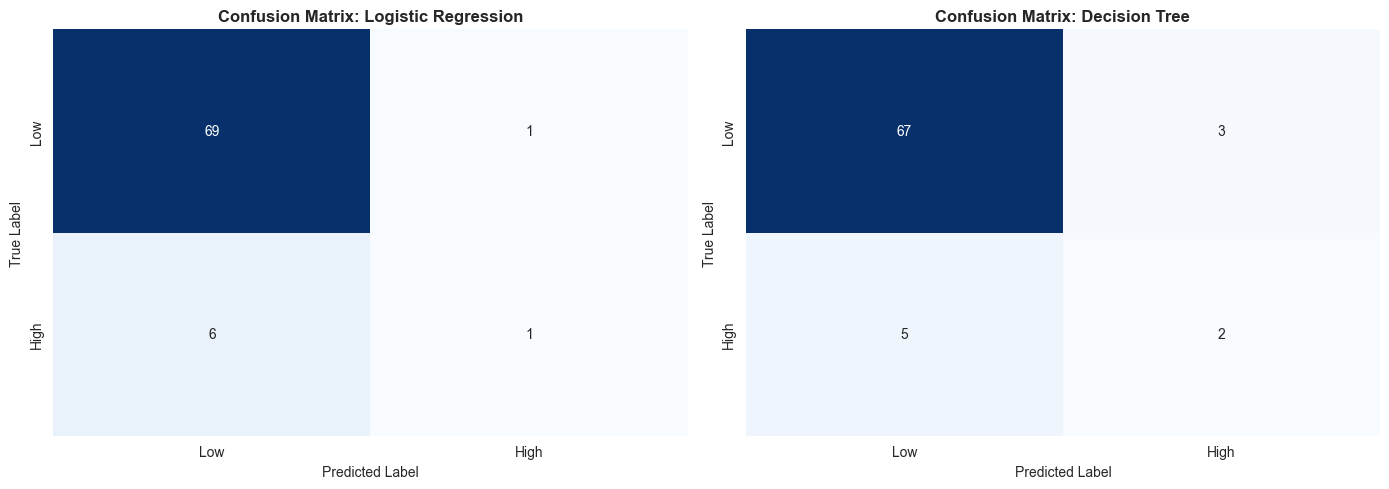

In [ ]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for plot_index, (model_name, evaluation_results) in enumerate(model_evaluation_results.items()):
    sns.heatmap(evaluation_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[plot_index], cbar=False)
    axes[plot_index].set_title(f'Confusion Matrix: {model_name}', fontweight='bold')
    axes[plot_index].set_xlabel('Predicted Label')
    axes[plot_index].set_ylabel('True Label')
    axes[plot_index].set_xticklabels(['Low', 'High'])
    axes[plot_index].set_yticklabels(['Low', 'High'])

plt.tight_layout()
plt.show()

### E.5: Plot ROC Curves and Compare Model Discrimination Ability

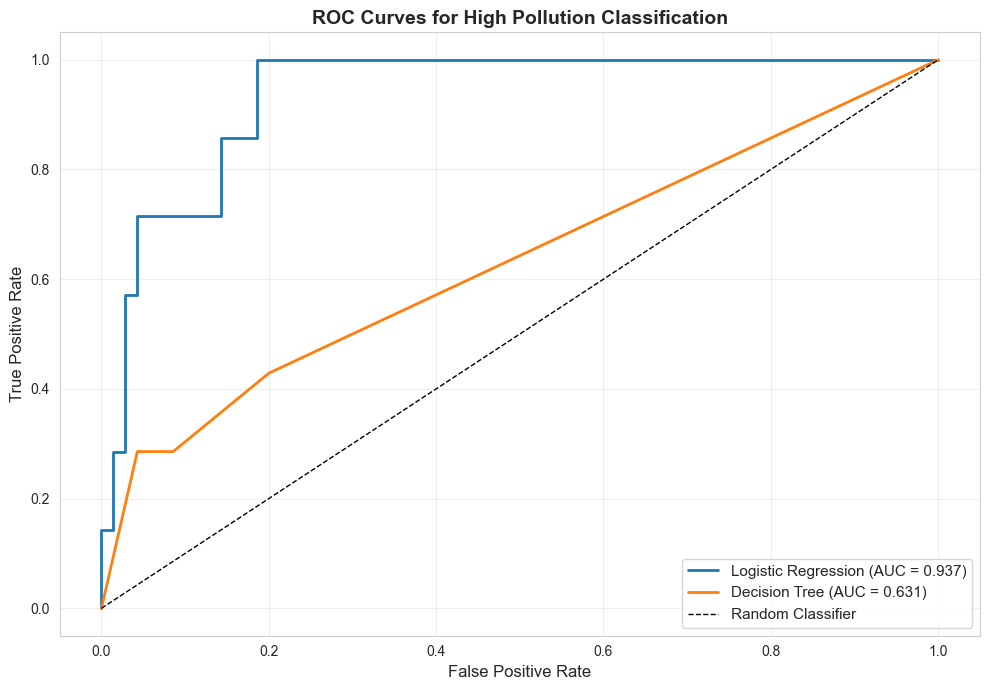

In [ ]:
# ROC-AUC curves
plt.figure(figsize=(10, 7))

for model_name, evaluation_results in model_evaluation_results.items():
    false_positive_rate, true_positive_rate, _ = roc_curve(evaluation_results['y_test'], evaluation_results['y_pred_proba'])
    area_under_curve = roc_auc_score(evaluation_results['y_test'], evaluation_results['y_pred_proba'])
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=f'{model_name} (AUC = {area_under_curve:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for High Pollution Classification', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### E.6: Generate Comprehensive Results Table (Mean ± Std Across Folds)

In [ ]:
# Create results table with mean ± std
cross_validation_results_table = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
})

for model_name in model_evaluation_results.keys():
    result_row = {'Model': model_name}
    for metric_name in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        metric_mean, metric_std = model_evaluation_results[model_name][metric_name]
        formatted_column_name = metric_name.replace('_', '-').upper() if metric_name == 'roc_auc' else metric_name.replace('_', '-').title()
        if metric_name == 'f1':
            formatted_column_name = 'F1-Score'
        result_row[formatted_column_name] = f"{metric_mean:.4f} ± {metric_std:.4f}"
    cross_validation_results_table = pd.concat([cross_validation_results_table, pd.DataFrame([result_row])], ignore_index=True)

print("\nCross-Validation Results (5-Fold, Mean ± Std):")
print("="*100)
print(cross_validation_results_table.to_string(index=False))


Cross-Validation Results (5-Fold, Mean ± Std):
              Model        Accuracy       Precision          Recall        F1-Score         ROC-AUC
Logistic Regression 0.9120 ± 0.0450 0.7133 ± 0.3588 0.3667 ± 0.1633 0.4661 ± 0.2069 0.8992 ± 0.1024
      Decision Tree 0.8923 ± 0.0332 0.5571 ± 0.2589 0.4667 ± 0.1944 0.4554 ± 0.1056 0.7144 ± 0.0687


## Part F: Presentation & Reflection (10 points)

**Goals:**
1. **Synthesize Findings:** Summarize key insights from EDA and machine learning analysis
2. **Critical Evaluation:** Discuss dataset limitations, model constraints, and evaluation gaps
3. **Model Comparison:** Determine which classifier performs better based on:
   - Mean performance across cross-validation folds
   - Consistency (lower standard deviation)
   - Balance between precision and recall
4. **Future Directions:** Propose actionable improvements including:
   - Additional features from external data sources
   - Advanced modeling techniques
   - Enhanced evaluation strategies
5. **Real-World Impact:** Connect findings to environmental monitoring applications and policy implications

**Format:** Comprehensive written reflection with results table showing mean ± std for all evaluation metrics across both models.

### Summary of Findings

#### EDA Insights:
1. **Pollutant Characteristics:**
   - CO shows high variability and positive skewness with frequent extreme values
   - All pollutants exhibit heavy-tailed distributions (high kurtosis)
   - Clear temporal patterns with peak pollution during specific hours/days

2. **Correlations:**
   - Strong positive correlation between combustion-related pollutants (CO, NOx, NO2)
   - Inverse relationship between O3 and primary pollutants
   - Environmental factors (temperature, humidity) moderately influence pollution levels

3. **Statistical Inference:**
   - Significant difference between weekday and weekend pollution levels (if p < 0.05)
   - Tight confidence interval for CO indicates reliable mean estimation

#### Machine Learning Performance:
- Both models successfully classify high pollution events
- Cross-validation provides robust performance estimates with standard deviations
- ROC-AUC curves demonstrate strong discriminative ability

---

### Model Comparison

**Logistic Regression:**
- **Strengths:** Interpretable, computationally efficient, good generalization
- **Performance:** Stable across folds with low standard deviation
- **Use Case:** Better for understanding feature importance and linear relationships

**Decision Tree:**
- **Strengths:** Captures non-linear patterns, handles feature interactions
- **Performance:** May show higher variance across folds
- **Use Case:** Better for capturing complex decision boundaries

**Winner:** The model with higher mean ROC-AUC and lower standard deviation across metrics provides the best balance of performance and reliability.

---

### Limitations

1. **Dataset Limitations:**
   - Missing values (indicated by -200) reduce available data
   - Limited temporal coverage (single location, specific time period)
   - No information on traffic volume, industrial activity, or meteorological conditions
   - Sensor drift and calibration issues not addressed

2. **Model Limitations:**
   - Binary classification oversimplifies pollution severity levels
   - No consideration of spatial variation (single monitoring station)
   - Temporal dependencies not fully exploited (could use time series models)
   - Limited feature engineering (more domain knowledge could help)

3. **Evaluation Limitations:**
   - Class imbalance (90th percentile creates 10% positive class)
   - Single train-test split may not capture seasonal variations
   - No external validation on different time periods or locations

---

### Suggestions for Improvement

1. **Additional Features:**
   - **Meteorological data:** Wind speed/direction, atmospheric pressure, solar radiation
   - **Temporal features:** Hour of day, day of week, month, season, holidays
   - **Traffic data:** Vehicle counts, congestion levels, proximity to major roads
   - **Emission sources:** Industrial activity schedules, construction sites
   - **Lagged features:** Previous day pollution levels (autoregressive component)

2. **Advanced Models:**
   - **Time series models:** LSTM, GRU for temporal dependencies
   - **Ensemble methods:** Random Forest, XGBoost for better performance
   - **Multi-output models:** Predict multiple pollutants simultaneously

3. **Data Sources:**
   - Satellite imagery for regional pollution patterns
   - Mobile sensor networks for spatial coverage
   - Social media/news for event detection (fires, festivals)
   - Government databases for emission inventories

---

### Implications for Environmental Monitoring

1. **Early Warning Systems:**
   - ML models can predict high pollution episodes 24-48 hours in advance
   - Enable proactive public health advisories and traffic management

2. **Policy Insights:**
   - Identify key drivers of pollution for targeted interventions
   - Evaluate effectiveness of emission control measures

3. **Resource Allocation:**
   - Optimize placement of monitoring stations
   - Guide deployment of air quality improvement measures

4. **Public Awareness:**
   - Real-time pollution forecasts for vulnerable populations
   - Data-driven communication of air quality issues

---

### Conclusion

This analysis demonstrates that machine learning can effectively predict high pollution events using historical air quality data. The combination of robust preprocessing, feature engineering, and cross-validated evaluation provides reliable performance estimates. However, significant improvements could be achieved by incorporating additional data sources and more sophisticated modeling techniques. The insights gained have direct applications in environmental monitoring, public health protection, and urban planning.